In [1]:
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import Input, Dense, Subtract, Add, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from keras.utils.layer_utils import count_params
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

In [2]:
# 读取数据
load_path = '../global_data/time_76800x128x9x9/'

trials = np.load(load_path + 'trials.npy')
bases = np.load(load_path + 'bases.npy')
labels = np.load(load_path + 'labels.npy')
print(trials.shape, bases.shape, labels.shape)

(76800, 128, 9, 9) (1280, 128, 9, 9) (1280, 2)


## 数据预处理

In [3]:
# 从 chw 转换为 hwc
print(K.image_data_format())
trials = trials.transpose((0, 2, 3, 1))
bases = bases.transpose((0, 2, 3, 1))
print(trials.shape, bases.shape)

channels_last
(76800, 9, 9, 128) (1280, 9, 9, 128)


In [4]:
# 去基线
trials_de_base = []
for i, base in enumerate(bases):
    trials_de_base.append(trials[i * 60 : (i + 1) * 60] - base)
trials_de_base = np.array(trials_de_base)
trials_de_base = trials_de_base.reshape((-1, 9, 9, 128))
trials_de_base.shape

(76800, 9, 9, 128)

In [5]:
# 离散化标签
labels = np.where(labels >= 5, 1, 0)

# 复制以对齐样本
labels = np.repeat(labels, 60, axis = 0)
print(labels.shape)

(76800, 2)


In [32]:
# sample_cnt = trials.shape[0]
# # 数据集划分
# train_ratio = 0.9
# shuffer_list = np.arange(sample_cnt)
# np.random.shuffle(shuffer_list)

# trials_shuffer = trials_de_base[shuffer_list] # trials_de_base
# labels = labels[shuffer_list]

# x_train = trials_shuffer[:int(train_ratio * sample_cnt)]
# y_train = labels[:int(train_ratio * sample_cnt)]
# x_test = trials_shuffer[int(train_ratio * sample_cnt):]
# y_test = labels[int(train_ratio * sample_cnt):]

In [41]:
SEED = 2022
tf.random.set_seed(SEED)

In [42]:
# 超参设置
max_epoch = 40

In [46]:
def cnn2_dens2(shape):
    input_layer = Input(shape=shape)
    conv1 = Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu', use_bias = True)(input_layer)
    # maxpool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    conv2 = Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu', use_bias = True)(conv1)
    # maxpool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
#     Dropout(0.25)(maxpool2)

    fl = Flatten()(conv2)
    fc1 = Dense(128, activation = 'relu')(fl)
    dp1 = Dropout(0.5)(fc1)
    fc2 = Dense(64,activation='relu')(dp1)
#     bn = BatchNormalization()(fc1)
    dp2 = Dropout(0.5)(fc2)

    out_layer = Dense(2, activation = 'softmax')(dp2)

    model = Model(inputs=[input_layer], outputs=[out_layer])

    optimizer = Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])
    # 可选 categorical_crossentropy

#     model.summary()

    os.environ["PATH"] += os.pathsep +'C:/Program Files/Graphviz/bin'
    plot_model(model,'cnn2_dens2.jpg', show_shapes=True)
    
    return model

In [55]:
all_acc = []
for idx in range(32):
    print(f'sub:{idx}')
    sample_cnt = 2400

    # 数据集划分
    train_ratio = 0.7
    shuffer_list = np.arange(sample_cnt)
    np.random.shuffle(shuffer_list)
    trials_de_base_1sub = trials_de_base[idx*sample_cnt:(idx+1)*sample_cnt]
    labels_1sub = labels[idx*sample_cnt:(idx+1)*sample_cnt]

    trials_shuffer = trials_de_base_1sub[shuffer_list] # trials_de_base
    labels_shuffer = labels_1sub[shuffer_list]

    x_train = trials_shuffer[:int(train_ratio * sample_cnt)]
    y_train = labels_shuffer[:int(train_ratio * sample_cnt)]
    x_test = trials_shuffer[int(train_ratio * sample_cnt):]
    y_test = labels_shuffer[int(train_ratio * sample_cnt):]


    # z归一化

    chan_to_1020={0:[0,3],1:[1,3],2:[2,2],3:[2,0],4:[3,1],5:[3,3],6:[4,2],7:[4,0],8:[5,1],9:[5,3],10:[6,3],11:[6,0],12:[7,3],
                    13:[8,3],14:[7,4],15:[6,4],16:[0,5],17:[1,5],18:[2,4],19:[2,6],20:[2,8],21:[3,7],22:[3,5],23:[4,4],24:[4,6],
                    25:[4,8],26:[5,7],27:[5,5],28:[6,6],29:[6,8],30:[7,5],31:[8,5]}

    # 需要归一化的位置
    need_norm_pos = np.zeros(shape=(9,9))

    for val in chan_to_1020.values():
        need_norm_pos[val[0]][val[1]] = 1
#     print(need_norm_pos)

    x_train = x_train.reshape((x_train.shape[0], -1))
    x_test = x_test.reshape((x_test.shape[0], -1))

    need_norm_pos = need_norm_pos.reshape(-1)

    for i, need_norm in enumerate(need_norm_pos):
        if need_norm == 1:
            mean = np.mean(x_train[:, i * 128 : (i + 1) * 128], axis = 0)
            std = np.std(x_train[:, i * 128 : (i + 1) * 128], axis = 0)
            x_train[:, i * 128 : (i + 1) * 128] -= mean
            x_train[:, i * 128 : (i + 1) * 128] /= std
            x_test[:, i * 128 : (i + 1) * 128] -= mean
            x_test[:, i * 128 : (i + 1) * 128] /= std

    x_train = x_train.reshape((-1, 9, 9, 128))
    x_test = x_test.reshape((-1, 9, 9, 128))


    # 处理成 tf 的输入格式
    y_v_train = to_categorical(y_train[:, 0], 2)
    y_a_train = to_categorical(y_train[:, 1], 2)
    y__v_test = to_categorical(y_test[:, 0], 2)
    y__a_test = to_categorical(y_test[:, 1], 2)


    # 建立模型

    model = cnn2_dens2(shape = x_train.shape[1:])

    # Train the model
    callbacksList = [EarlyStopping(monitor = 'val_acc', patience=10, verbose = 1), # patience当连续多少个epochs时验证集精度不再变好终止训练
                    ModelCheckpoint(filepath = f'model/model.h5',monitor='acc',save_best_only=True,)
    ]

    history = model.fit(x=[x_train], y=y_v_train, 
                        validation_data=(x_test, y__v_test), shuffle = True,
                        callbacks = callbacksList,
                        epochs=max_epoch, batch_size = 32, verbose=0)
    
    # 评估
    model = load_model('model/model.h5')
    score = model.evaluate(x_test, y__v_test, verbose = 1)
    all_acc.append(score[1])

all_acc = np.array(score[1])
print(all_acc.mean())

sub:0
Epoch 37: early stopping
23/23 [==============================] - 0s 8ms/step - loss: 0.1448 - acc: 0.9764
sub:1
Epoch 29: early stopping
23/23 [==============================] - 0s 6ms/step - loss: 0.2861 - acc: 0.9611
sub:2
Epoch 18: early stopping
23/23 [==============================] - 0s 6ms/step - loss: 0.2823 - acc: 0.9750
sub:3
Epoch 22: early stopping
23/23 [==============================] - 0s 6ms/step - loss: 0.3242 - acc: 0.9236
sub:4
Epoch 16: early stopping
23/23 [==============================] - 0s 6ms/step - loss: 0.1914 - acc: 0.9583
sub:5
Epoch 22: early stopping
23/23 [==============================] - 0s 6ms/step - loss: 0.1375 - acc: 0.9681
sub:6
Epoch 22: early stopping
23/23 [==============================] - 0s 6ms/step - loss: 0.0927 - acc: 0.9806
sub:7
Epoch 37: early stopping
23/23 [==============================] - 0s 12ms/step - loss: 0.3564 - acc: 0.9611
sub:8
Epoch 25: early stopping
23/23 [==============================] - 0s 9ms/step - loss: 0.3

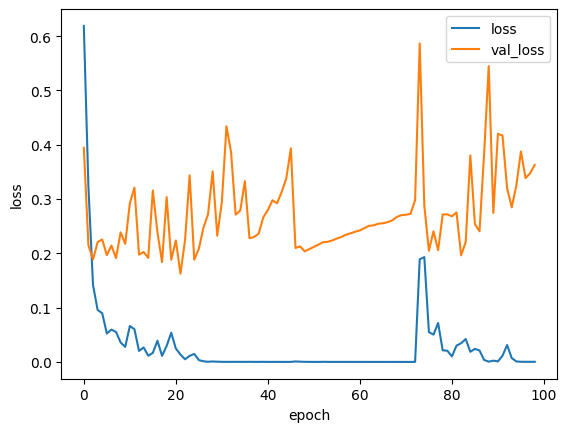

In [39]:
# 查看训练曲线
plt.plot(history.epoch,history.history.get('loss'),label="loss")
plt.plot(history.epoch,history.history.get('val_loss'),label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()


In [ ]:
plt.plot(history.epoch,history.history.get('acc'),label="accuracy")
plt.plot(history.epoch,history.history.get('val_acc'),label="val_accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()


In [ ]:
# # 评估
# score = model.evaluate(x_test, y_test, verbose = 0) 
# print('Test loss:', score[0]) 
# print('Test accuracy:', score[1])

# # 预测
# pred = model.predict(x_test) 
# pred = np.argmax(pred, axis = 1)[:5] 
# label = np.argmax(y_test,axis = 1)[:5] 
# print(pred) 
# print(label)
